In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from pathlib import Path, PureWindowsPath
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', None) #afficher texte entier dans dataframe

In [2]:
current_folder = PureWindowsPath(globals()['_dh'][0]).as_posix()
path_root = "/".join(current_folder.split("/")[:-2]) #remonter au dossier root du projet
os.chdir(path_root)
path = PureWindowsPath(os.getcwd() + "/data/input/data.parquet")
path = path.as_posix() #convertir en path linux (convertir les \\ en /)
corpus = pd.read_parquet(path) #engine="fastparquet"

zeros_subset = corpus.loc[corpus["category_bin"] == 0, :]
ones_subset = corpus.loc[corpus["category_bin"] == 1, :]
number_of_minority_class = len(zeros_subset)
sampled_ones = ones_subset.sample(number_of_minority_class, random_state=42)
print(sampled_ones.shape)
corpus = pd.concat([sampled_ones, zeros_subset], ignore_index=True)
corpus = corpus.sample(frac=1).reset_index(drop=True)
corpus.index = list(range(len(corpus)))
corpus["id"] = corpus.index	#creation de l'id seulement apres equilibrage des classes et melange aleatoire
print(corpus["category_bin"].value_counts())
print(corpus.id.duplicated().any()) #Verifier qu'il n'y a pas d'id en doublon
print(corpus.index.duplicated().any())
corpus

(1825, 6)
0    1825
1    1825
Name: category_bin, dtype: int64
False
False


,id,message,message_preprocessed,category,length,category_bin
0,0,Maxime N. Georgel sur 1 mars 2019 à 16 h 33 min,maxime georgel mar heure min,baptism,47,0
1,1,"11. FRAME, _Cornelius Van Til: An Analysis of His Thought_ , p. 192–197.[↩]",frame cornelius van til an analysis of his thought p –↩,philosophy,77,1
2,2,"Pour être clair : il ne s’agit pas d’opposer régénération et baptême, mais de questionner la place de l’un et de l’autre.",être clair agit opposer régénération baptême questionner place autre,baptism,122,0
3,3,"8. La doctrine de Thomas d’Aquin sur l’analogie de l’être, _l’analogia entis_ , est un sujet complexe et controversé, et une discussion approfondie dépasse largement le cadre de cet article déjà long. Une grande partie du débat actuel porte sur la question de savoir si la doctrine de l’analogie de Thomas d’Aquin est une analogie de proportionnalité appropriée. C’était l’interprétation dominante chez les thomistes jusqu’au XXe siècle. Parmi ceux qui ont plaidé en faveur d’une certaine version de ce point de vue se trouvent Tommaso de Vio Cajetan, Reginald Garrigou-Lagrange, Jacques Maritain, James Anderson, Edward Feser, et Steven A. Long. Cette vision traditionnelle a été rejetée par la plupart des thomistes contemporains (mais certainement pas tous) qui soutiennent que Thomas d’Aquin a abandonné l’analogie de la proportionnalité appropriée pour une analogie d’attribution. Parmi ceux qui défendent le point de vue contemporain se trouvent George Klubertanz, Bernard Montagnes et Ralph McInerny. Je crois que l’interprétation traditionnelle de Thomas d’Aquin est correcte sur ce point. Quoi qu’il en soit, le débat ne porte pas sur la question de savoir si Thomas d’Aquin a brouillé ou non les frontières entre le Créateur et la créature. Pour des discussions utiles sur ce que Thomas d’Aquin enseigne au sujet de l’analogie et les débats entourant son enseignement, voir, DE VIO, Tommaso dit Cajétan, _The Analogy of Names, and the Concept of Being_ , BUSHINSKI, Edward A. (trad.), Eugene, Ore. : Wipf & Stock, 1953 ; MCINERNY, Ralph, _Aquinas on Analogy_ , Washington, D.C. : Catholic University of America Press, 1996 ; WIPPEL, John F., _The Metaphysical Thought of Thomas Aquina_ s, Washington, D.C. : Catholic University of America Press, 2000, p. 501–575 ; MORTENSEN, John R. , _Understanding St. Thomas on Analogy_ , Rome : Aquinas Institute for the Study of Sacred Doctrine, 2006 ; LONG, Steven A., _Analogia Entis_ , Notre Dame, Ind. : University of Notre Dame Press, 2011 ; KLIMA, Gyula, “Theory of Language,” dans _The Oxford Handbook of Aquinas_ , DAVIES, Brian, STUMP, Eleonore (éds.), Oxford, England : Oxford University Press, 2012, p. 379–385.[↩]",doctrine thomas aquin analogie être analogia entis sujet complexe controversé discussion approfondie dépasse largement cadre cet article déjà long grand partie débat actuel porte question savoir si doctrine analogie thomas aquin analogie proportionnalité appropriée interprétation dominante chez thomiste xxe siècle parmi ceux plaidé faveur certaine version point vue trouvent tommaso vio cajetan reginald garrigou-lagrange jacques maritain james anderson edward feser steven a long cette vision traditionnelle a rejetée plupart thomiste contemporains certainement tous soutiennent thomas aquin a abandonné analogie proportionnalité appropriée analogie attribution parmi ceux défendent point vue contemporain trouvent george klubertanz bernard montagne ralph mcinerny crois interprétation traditionnelle thomas aquin correcte point quoi débat porte question savoir si thomas aquin a brouillé non frontière entre créateur créature discussion utile thomas aquin enseigne sujet analogie débat entourant enseignement voir vio tommaso dit cajétan the analogy of names and the concept of being bushinski edward a trad eugene ore wipf stock mcinerny ralph aquinas analogy washington dc catholic university of america press wippel john f the metaphysical thought of thomas aquina washington dc catholic uni

In [3]:
X = corpus["message_preprocessed"]
y = corpus["category"]
y = corpus["category_bin"]
indices = corpus["id"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)
# y_train.value_counts()
# print(indices_train, indices_test)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
indices_test

1313    1313
1674    1674
229      229
2974    2974
2222    2222
        ... 
1618    1618
819      819
100      100
3208    3208
3371    3371
Name: id, Length: 1205, dtype: int64

In [4]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score 

# Cross validation
#Methode version automatisee facile grace a la fonction RepeatedStratifiedKFold de sklearn
#Selection de modeles avec la k cross validation pour determiner le meilleur
#Modeles utilisés dans les papiers :
# LogisticRegression, MultinomialNB (= naive bayes), SVC (SVD petit data), SGDClassifier (SVD grand data)
# DecisionTreeClassifier, RandomForestClassifier
# AdaBoostClassifier, MLPClassifier
pd.set_option("display.precision", 2)
# scoring = ['accuracy', 'precision', 'recall', 'f1', 'f1_macro']
scoring = ['f1_macro', 'f1_micro']
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('AdaBoostClassifier', AdaBoostClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RandomForest', RandomForestClassifier()))
# models.append(('MLPClassifier', MLPClassifier(max_iter=500))) car diverge donc trop long
models.append(('SGDClassifier', SGDClassifier()))
models.append(('SVM', SVC()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
 
# evaluate each model in turn
results = []
names = []
num_iter = 2
for name, model in models:
    sum_test_accuracy = 0
    sum_test_f1 = 0
    sum_test_recall = 0
    sum_test_precision = 0
    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=num_iter, random_state=None)
    cv_results = cross_validate(model, X_train_tfidf, y_train, cv=kfold, scoring=scoring)
    for k, scores in cv_results.items():
        cv_results[k] = round(np.mean(scores), 4) #on fait la moyenne de chaque score (rappel, precision, etc.) pour les k experiences
    print((str(list(cv_results.items())[2:])+" ({0})").format(name)) #2: pour ignorer les info inutiles

[('test_f1_macro', 0.9451), ('test_f1_micro', 0.9452)] (LR)
[('test_f1_macro', 0.8993), ('test_f1_micro', 0.8998)] (AdaBoostClassifier)
[('test_f1_macro', 0.9299), ('test_f1_micro', 0.9301)] (KNN)
[('test_f1_macro', 0.9335), ('test_f1_micro', 0.9335)] (RandomForest)
[('test_f1_macro', 0.9488), ('test_f1_micro', 0.9489)] (SGDClassifier)
[('test_f1_macro', 0.9507), ('test_f1_micro', 0.9507)] (SVM)
[('test_f1_macro', 0.8924), ('test_f1_micro', 0.8926)] (DecisionTreeClassifier)


In [5]:
# Learning curves du modele selectionne : performances du modele en fonction de la taille du trainset
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#Entrees
    #train_sizes (liste de float) : tailles du train en pourcentage 
    #cv_param : parametres de type kfold pour la cross validation
def get_learning_curve(model, X_train, y_train, cv_param, scoring, train_sizes, n_jobs=-1):
    # print("train_sizes =", 100 * train_sizes * len(y_train))
    train_sizes, train_scores, cv_scores = learning_curve(model, X_train, y_train, cv=cv_param, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    # learning_curve(AdaBoostClassifier(), X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    cv_scores_std = np.std(cv_scores, axis=1)
    model_name = str(model)
    plt.figure()
    train_plot_label = scoring.capitalize() + " sur le trainset"
    cv_plot_label = scoring.capitalize() + " sur le cvset"
    title = scoring.capitalize() + " sur le trainset et sur le cvset en fonction de la taille du trainset pour " + model_name
    plt.plot(train_sizes, train_scores_mean, label=train_plot_label, color="b")
    plt.plot(train_sizes, cv_scores_mean, label=cv_plot_label, color="r")
    plt.title(title)
    plt.xlabel("Taille du trainset", fontsize=12)
    plt.ylabel(scoring.capitalize(), fontsize=12)
    plt.legend(loc="upper right")
    plt.show()

k = 10
# kfold = StratifiedKFold(n_splits=k, random_state=None, shuffle=True) #n_splits = k de la k-fold cv, le nombre de fold
kfold = RepeatedStratifiedKFold(n_splits=k, n_repeats=2, random_state=None)
scoring = 'accuracy'
cv_param = kfold
num_experiences = 10
train_sizes = np.linspace(0.1, 1.0, num_experiences)
# train_sizes = np.linspace(0.001, 1.0, num_experiences)
n_jobs = -1

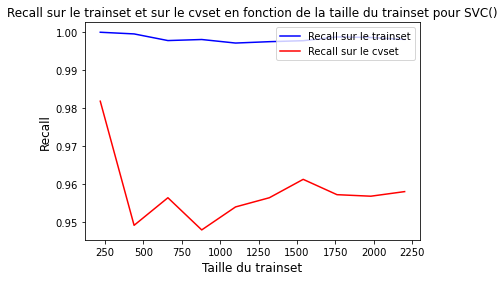

In [6]:
model = SVC() #le meilleur modele garde apres cross validation 
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "recall", train_sizes, n_jobs)

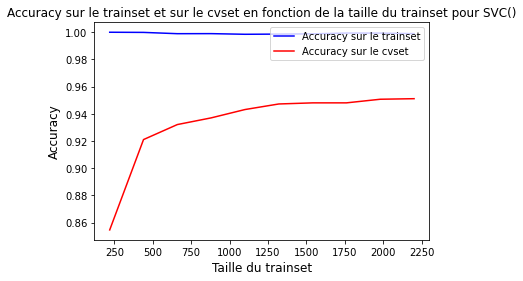

In [7]:
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "accuracy", train_sizes, n_jobs)

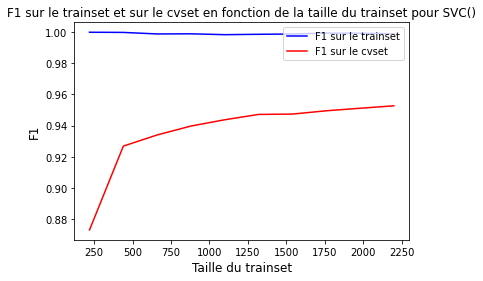

In [8]:
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "f1", train_sizes, n_jobs)

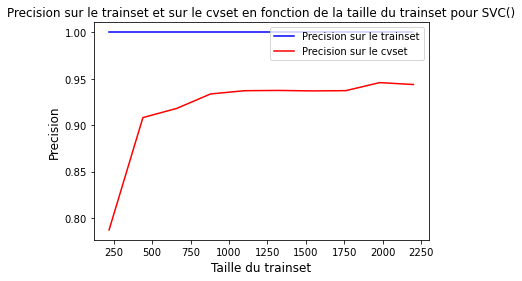

In [9]:
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "precision", train_sizes, n_jobs)